Выполним загрузку датасета [Pet Faces](https://www.soshnikov.com/permanent/data/petfaces.tar.gz)

In [ ]:
# !wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
# !rm petfaces.tar.gz

Выполним необходимые импорты

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
data_dir = 'petfaces'
all_dirs = sorted(os.listdir(data_dir))
print(all_dirs)

['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx', 'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']


Выполним предварительную обработку датасета и сформируем DataFrame

In [ ]:
cat_breed_names = [d for d in all_dirs if 'Cat' in d or 'cat' in d]
dog_breed_names = [d for d in all_dirs if d not in cat_breed_names]

records = []
class_idx = 0
breed_to_idx = {}

for breed_dir in all_dirs:
    breed_path = os.path.join(data_dir, breed_dir)
    if not os.path.isdir(breed_path):
        continue
    if breed_dir in cat_breed_names:
        species_label = 0
    else:
        species_label = 1

    breed_to_idx[breed_dir] = class_idx
    class_idx += 1

    image_files = glob.glob(os.path.join(breed_path, '*.*'))
    for f in image_files:
        records.append({
            'file_path': f,
            'class_name': breed_dir,
            'species': species_label,
            'class_id': breed_to_idx[breed_dir]
        })

df = pd.DataFrame(records)

In [ ]:
print(df['class_name'].value_counts().head(15))

class_name
dog_english         182
dog_american        174
cat_British         100
cat_Sphynx          100
cat_Siamese         100
cat_Birman           98
dog_newfoundland     98
cat_Russian          97
cat_Ragdoll          96
dog_leonberger       95
cat_Maine            95
cat_Persian          94
dog_havanese         93
cat_Abyssinian       92
dog_great            91
Name: count, dtype: int64


In [ ]:
print(df['species'].value_counts())

species
1    2105
0    1106
Name: count, dtype: int64


Возьмём 80% на обучение, 20% на тест

In [ ]:
test_size = 0.2
random_seed = 42

In [ ]:
import tensorflow as tf
from keras.preprocessing import image

IMG_SIZE = (128, 128)  # например

def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  # или decode_png
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

Бинарная классификация "Cat vs Dog"

In [ ]:
X = df['file_path'].values
y_binary = df['species'].values  # 0 или 1
sss_binary = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
train_idx_bin, test_idx_bin = next(sss_binary.split(X, y_binary))
X_train_bin, X_test_bin = X[train_idx_bin], X[test_idx_bin]
y_train_bin, y_test_bin = y_binary[train_idx_bin], y_binary[test_idx_bin]

train_bin_ds = tf.data.Dataset.from_tensor_slices((X_train_bin, y_train_bin))
train_bin_ds = train_bin_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_bin_ds = train_bin_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_bin_ds = tf.data.Dataset.from_tensor_slices((X_test_bin, y_test_bin))
test_bin_ds = test_bin_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_bin_ds = test_bin_ds.batch(32).prefetch(tf.data.AUTOTUNE)

Мультиклассовая классификация (36 классов)

In [ ]:
y_multiclass = df['class_id'].values
sss_multi = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
train_idx_multi, test_idx_multi = next(sss_multi.split(X, y_multiclass))
X_train_multi, X_test_multi = X[train_idx_multi], X[test_idx_multi]
y_train_multi, y_test_multi = y_multiclass[train_idx_multi], y_multiclass[test_idx_multi]

train_multi_ds = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
train_multi_ds = train_multi_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_multi_ds = train_multi_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_multi_ds = tf.data.Dataset.from_tensor_slices((X_test_multi, y_test_multi))
test_multi_ds = test_multi_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_multi_ds = test_multi_ds.batch(32).prefetch(tf.data.AUTOTUNE)


CNN для бинарной классификации

In [ ]:
from keras import layers, models

def build_binary_model(input_shape=(128,128,3)):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

binary_model = build_binary_model()
binary_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Обучение CNN для бинарной классификации

In [ ]:
EPOCHS = 10
history_bin = binary_model.fit(
    train_bin_ds,
    epochs=EPOCHS,
    validation_data=test_bin_ds
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.6248 - loss: 0.7165 - val_accuracy: 0.7154 - val_loss: 0.5536
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8415 - loss: 0.3898 - val_accuracy: 0.8771 - val_loss: 0.2661
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9025 - loss: 0.2562 - val_accuracy: 0.8927 - val_loss: 0.2397
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9285 - loss: 0.1835 - val_accuracy: 0.9191 - val_loss: 0.2360
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9302 - loss: 0.1774 - val_accuracy: 0.8927 - val_loss: 0.3215
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9331 - loss: 0.1757 - val_accuracy: 0.9285 - val_loss: 0.2062
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9624 - loss: 0.0913 - val_accuracy: 0.9191 - val_loss: 0.2860
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9633 - loss: 0.0962 - val_accuracy: 0.9176 - v

Accuracy на обучении и валидации

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9241 - loss: 0.2437


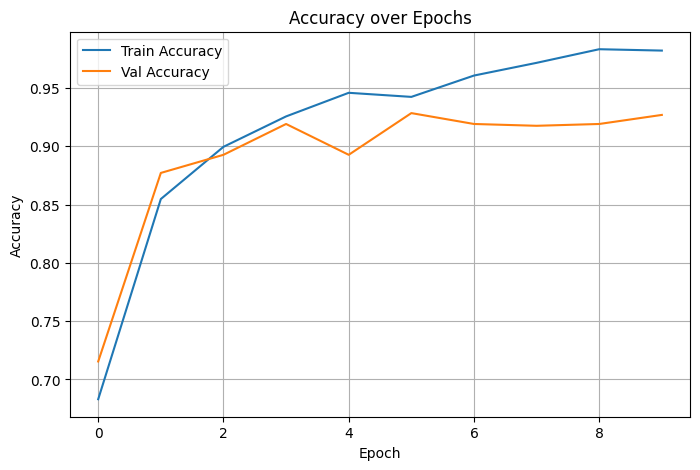

In [ ]:
import matplotlib.pyplot as plt

loss_bin, acc_bin = binary_model.evaluate(test_bin_ds)

history = history_bin.history

plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Точность бинарной классификации (cats vs dogs)

In [ ]:
print(f"{acc_bin:.4f}")

0.9269


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


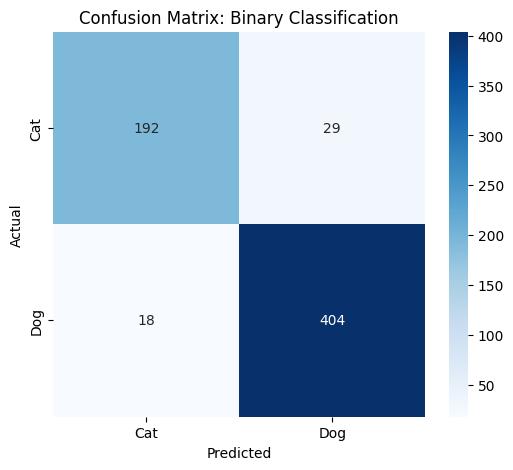

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_bin = binary_model.predict(test_bin_ds)
y_pred_bin_labels = (y_pred_bin >= 0.5).astype(int).ravel()
cm_bin = confusion_matrix(y_test_bin, y_pred_bin_labels)
labels = ['Cat', 'Dog']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Binary Classification')
plt.show()

CNN для многоклассовой классификации

In [ ]:
NUM_CLASSES = 36

def build_multiclass_model(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

multiclass_model = build_multiclass_model()
multiclass_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,525,284 (24.89 MB)

 Trainable params: 6,525,284 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

Обучение CNN для многоклассовой классификации

In [ ]:
EPOCHS = 10
history_multi = multiclass_model.fit(
    train_multi_ds,
    epochs=EPOCHS,
    validation_data=test_multi_ds
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.0491 - loss: 3.5874 - val_accuracy: 0.1757 - val_loss: 3.0628
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2057 - loss: 2.8593 - val_accuracy: 0.3515 - val_loss: 2.2860
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4344 - loss: 1.9573 - val_accuracy: 0.4339 - val_loss: 2.0203
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6023 - loss: 1.3587 - val_accuracy: 0.4588 - val_loss: 1.8686
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7345 - loss: 0.9023 - val_accuracy: 0.5101 - val_loss: 1.9044
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8154 - loss: 0.6065 - val_accuracy: 0.4914 - val_loss: 2.3157
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8913 - loss: 0.3537 - val_accuracy: 0.5070 - val_loss: 2.3647
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9155 - loss: 0.2648 - val_accuracy: 0.4930 - 

Accuracy на обучении и валидации

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5148 - loss: 3.0417


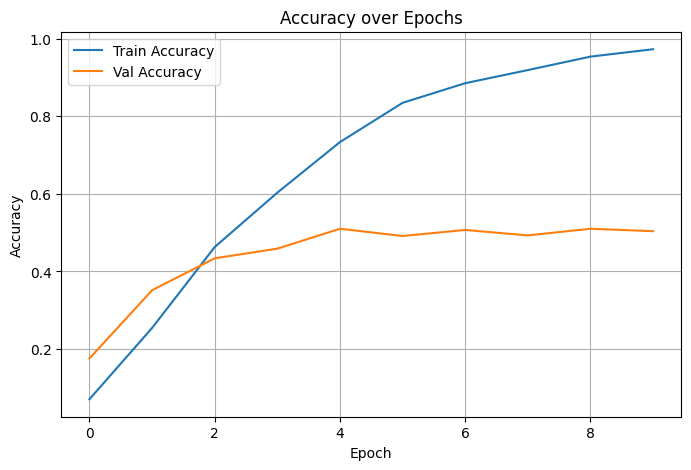

In [ ]:
import matplotlib.pyplot as plt

loss_multi, acc_multi = multiclass_model.evaluate(test_multi_ds)

history = history_multi.history

plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

На графике видно расхождение train accuracy и val accuracy. Для увеличения val accuracy пробовал использовать больше свёрточных слоёв, dropout и batch-normalization. Перебрав различные архитектуры, решил остановиться на данной.

Точность мультиклассовой классификации

In [ ]:
print(f"{acc_multi:.4f}")

0.5039


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


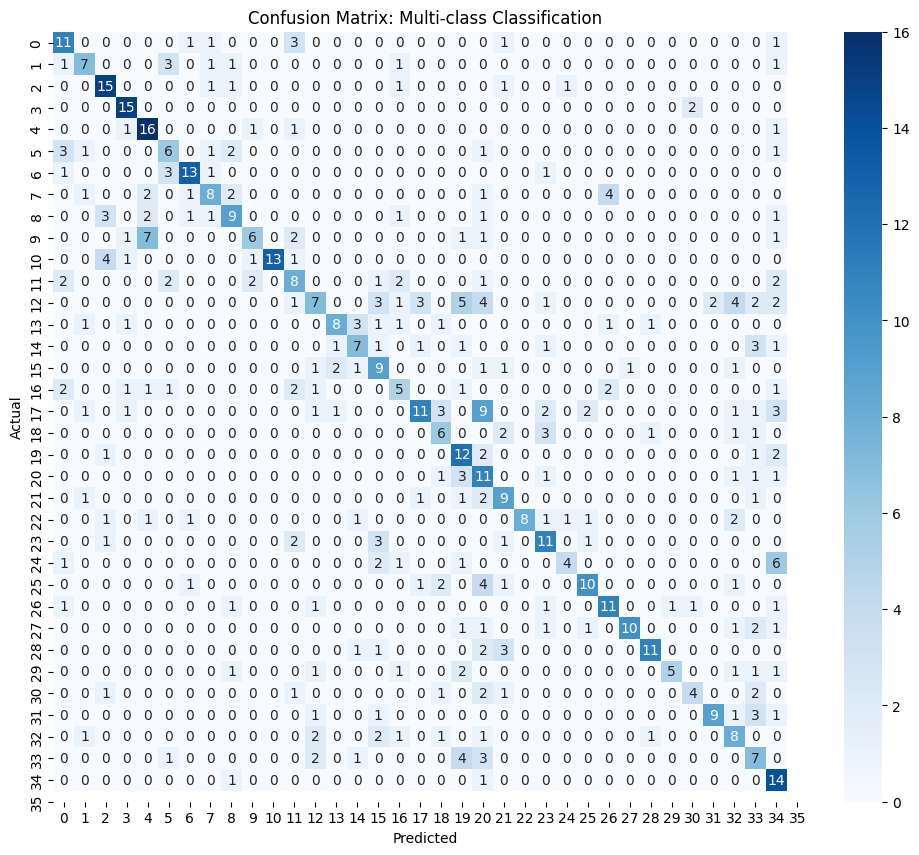

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_multi = multiclass_model.predict(test_multi_ds)
y_pred_multi_labels = np.argmax(y_pred_multi, axis=1)
cm_multi = confusion_matrix(y_test_multi, y_pred_multi_labels)
labels = [str(i) for i in range(NUM_CLASSES)]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Multi-class Classification')
plt.show()

Подсчёт топ-3 accuracy

In [ ]:
def top_k_accuracy_score(y_true, y_pred_proba, k=3):
    top_k_preds = np.argsort(y_pred_proba, axis=1)[:, -k:]
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in top_k_preds[i]:
            correct += 1
    return correct / len(y_true)

top3_acc = top_k_accuracy_score(y_test_multi, y_pred_multi, k=3)
print(f"Top-3 Accuracy (multi-class): {top3_acc:.4f}")


Top-3 Accuracy (multi-class): 0.7294


Попробуем выполнить оптимизацию гиперпараметров нейросети.

Имеются два варианта:
- Ручной перебор (Grid или Random Search)
- [Keras Tuner](https://keras.io/keras_tuner/)

Воспользуемся последним.

In [ ]:
# !pip install keras-tuner

Определим фукцию для перебора различных сочетаний гиперпараметров

In [ ]:
import tensorflow as tf
from keras import layers, models
import keras_tuner as kt

def model_builder(hp):

    dropout1 = hp.Float('dropout1', 0.1, 0.5, step=0.1)
    dropout2 = hp.Float('dropout2', 0.1, 0.5, step=0.1)
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_shape = (128, 128, 3)
    num_classes = 36

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout1))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout2))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

Тюнер

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='petfaces_tuning'
)

EPOCHS = 5
tuner.search(train_multi_ds,
             epochs=EPOCHS,
             validation_data=test_multi_ds)

Reloading Tuner from my_tuner_dir/petfaces_tuning/tuner0.json


Осуществляем поиск лучших гиперпараметров

In [ ]:
EPOCHS = 7
tuner.search(train_multi_ds,
             epochs=EPOCHS,
             validation_data=test_multi_ds)

Лучшие значения гиперпараметров

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense_units': 512, 'learning_rate': 0.001}


Соберём и обучим лучшую модель

In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_multi_ds,
    epochs=15,
    validation_data=test_multi_ds
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.0594 - loss: 3.6495 - val_accuracy: 0.1757 - val_loss: 3.0307
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2348 - loss: 2.7644 - val_accuracy: 0.3390 - val_loss: 2.2853
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4354 - loss: 1.9695 - val_accuracy: 0.4401 - val_loss: 1.9772
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5681 - loss: 1.4810 - val_accuracy: 0.4386 - val_loss: 1.8984
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6756 - loss: 1.0640 - val_accuracy: 0.5054 - val_loss: 1.7943
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7501 - loss: 0.7970 - val_accuracy: 0.4837 - val_loss: 1.9562
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8111 - loss: 0.5822 - val_accuracy: 0.4759 - val_loss: 2.1096
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8492 - loss: 0.4330 - val_accuracy: 0.5008 - val_loss: 2

Точность лучшей модели

In [ ]:
loss_test, acc_test = best_model.evaluate(test_multi_ds)
print(f"{acc_test:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4964 - loss: 2.7207
0.4930


Как можем видеть, значительно улучшить ситуацию не вышло.